<a href="https://colab.research.google.com/github/edmenciab733/ecc_qiskit_fallfest/blob/main/challenge_quantumquipu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paquetes requeridos

In [1]:
%%capture
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-aer
!pip install pennylane
!pip install ipython-autotime
!python -m pip install pennylane pennylane-lightning-gpu custatevec-cu11 --upgrade
!pip install qiskit-machine-learning

In [32]:
!nvidia-smi

Sun Nov 12 19:56:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    40W / 300W |    574MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autotime

time: 281 µs (started: 2023-11-12 17:55:05 +00:00)


In [3]:
import pandas as pd
import pennylane  as qml
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

time: 2.29 s (started: 2023-11-12 17:55:05 +00:00)


# Datos

In [4]:
df_train = pd.read_csv("https://raw.githubusercontent.com/QuantumQuipu/QuantumChallenge/main/challenge_train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/QuantumQuipu/QuantumChallenge/main/challenge_test.csv")

time: 1.09 s (started: 2023-11-12 17:55:07 +00:00)


In [5]:
df_train.drop(df_train.columns[0], axis=1, inplace=True)
df_test.drop(df_test.columns[0], axis=1, inplace=True)

time: 15 ms (started: 2023-11-12 17:55:08 +00:00)


In [6]:
df_test.head()

,F1,F2,F3,F4,Target
0,1.866088,1.574254,0.138930,-0.351542,1
1,0.839427,-1.069518,-0.432655,-0.964800,0
2,0.557187,-0.921264,-0.379198,-0.003020,0
3,-0.694573,1.875495,0.533211,0.659735,1
4,-1.844339,-1.116098,1.074549,-0.156043,0


time: 11.9 ms (started: 2023-11-12 17:55:08 +00:00)


In [7]:
print(df_train.shape, df_test.shape)

(800, 5) (200, 5)
time: 433 µs (started: 2023-11-12 17:55:08 +00:00)


## Datos Balanceados

<Axes: >

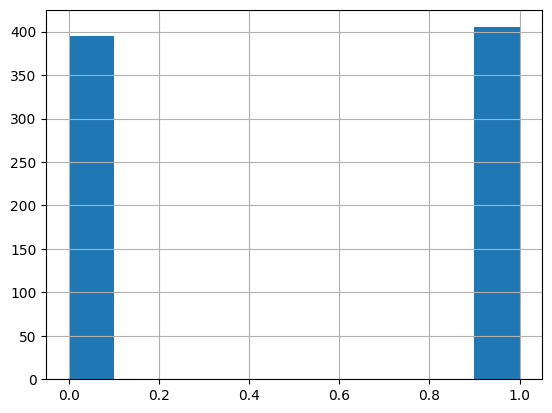

time: 209 ms (started: 2023-11-12 17:55:08 +00:00)


In [8]:
df_train["Target"].hist()

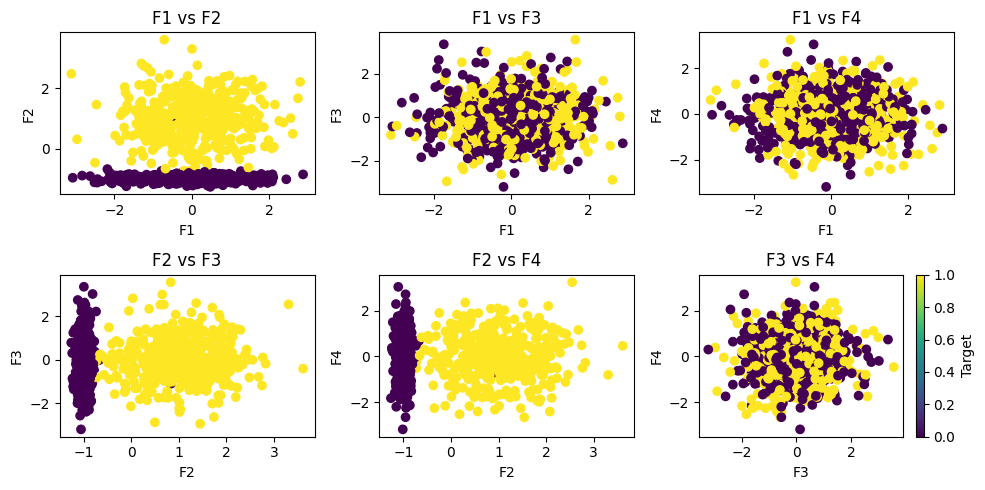

time: 1.07 s (started: 2023-11-12 17:55:08 +00:00)


In [9]:
features = ['F1', 'F2', 'F3', 'F4']


fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes = axes.ravel()

# Crear los gráficos
for i, (feature1, feature2) in enumerate(combinations(features, 2)):
    ax = axes[i]
    scatter = ax.scatter(df_train[feature1], df_train[feature2], c=df_train['Target'])
    ax.set_title(f'{feature1} vs {feature2}')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)


for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


fig.colorbar(scatter, label='Target')

# Mostrar el gráfico
plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot
plt.show()


## PCA

[1.49141493 1.07626371 0.98609999 0.92975252 0.0486541 ]
[32.90719263 23.74712524 21.75771594 20.51444213  1.07352406]
[ 32.90719263  56.65431787  78.41203381  98.92647594 100.        ]


Text(0, 0.5, 'Varianza explicada Acumulada')

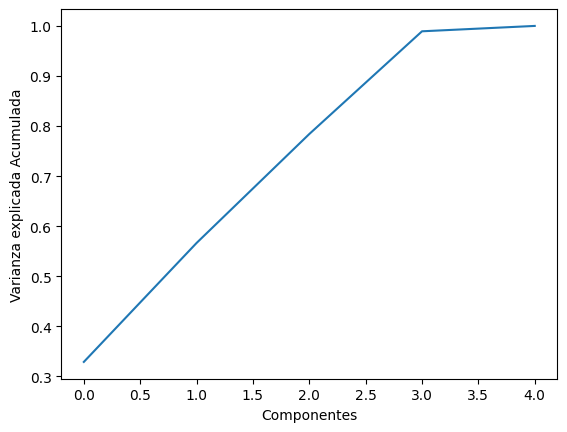

time: 352 ms (started: 2023-11-12 17:55:09 +00:00)


In [10]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_train)
X = pca.transform(df_train)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_ * 100)
print(pca.explained_variance_ratio_.cumsum() *100)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Componentes')
plt.ylabel('Varianza explicada Acumulada')
# Con el pca, notamos que con dos dimensiones se puede explicar el 97 por ciento de la varianza de las muestras. Lo que se puede verificar en la propia gráfica anterior, ya que todas
# combinaciones de dos dimensiones.
# Ademas se hacen precisiones con un modelo de Arbol de Desición, la intención es demostrar que tanto de precisión, se pierde o gana como menos columnas.

Las 3 primeras columnas explican lo 98% de los datos para el tanto para El AngleEmbedding como el ZZFeaturedMap podriamos usar solo 3 qubits. Inicialmente probaremos con la totalidad pero más abajo veremos si el mejor modelo es uno de los, podriamos reducir el tiempo sin ver que se pierdo tanto acurracy

## Datos adicionales de la composición de nuestros datos

In [11]:
df_train.describe()

,F1,F2,F3,F4,Target
count,800.000000,800.000000,800.000000,800.000000,800.000000
mean,-0.022675,0.018758,0.011646,-0.020326,0.506250
std,1.003272,1.128938,1.030749,0.968716,0.500274
min,-3.118159,-1.263462,-3.213591,-3.197503,0.000000
25%,-0.713586,-0.995735,-0.680477,-0.652490,0.000000
50%,-0.021669,-0.508522,-0.003524,-0.011651,1.000000
75%,0.660294,1.000536,0.694698,0.645487,1.000000
max,2.879529,3.612707,3.561504,3.249360,1.000000


time: 20.9 ms (started: 2023-11-12 17:55:10 +00:00)


## Prepapración de los datos

In [12]:
x_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
x_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

time: 1.23 ms (started: 2023-11-12 17:55:10 +00:00)


In [13]:
scaler = MaxAbsScaler()
x_trscaler = scaler.fit_transform(x_train)

time: 1.43 ms (started: 2023-11-12 17:55:10 +00:00)


In [14]:
df_train["Target"].value_counts()

1    405
0    395
Name: Target, dtype: int64

time: 4.54 ms (started: 2023-11-12 17:55:10 +00:00)


In [15]:
x_trscaler

array([[-0.09351405,  0.51335636, -0.06345758,  0.52156551],
       [ 0.10503011,  0.43865928, -0.36516632,  0.14517601],
       [ 0.07311527,  0.41852907, -0.18166023, -0.22887792],
       ...,
       [ 0.21745571, -0.28535903, -0.33957967,  0.39072768],
       [-0.32939082,  0.14265007,  0.32825804, -0.47205864],
       [ 0.27475071,  0.45982156,  0.03640087, -0.21937293]])

time: 3.11 ms (started: 2023-11-12 17:55:10 +00:00)


In [16]:
x_tescaler = scaler.transform(x_test)

time: 577 µs (started: 2023-11-12 17:55:10 +00:00)


In [17]:
print(np.min(x_trscaler), np.max(x_trscaler))

-1.0 1.0
time: 855 µs (started: 2023-11-12 17:55:11 +00:00)


In [18]:
print(np.min(x_tescaler), np.max(x_tescaler))

-0.9224873419324917 0.951005868682001
time: 610 µs (started: 2023-11-12 17:55:15 +00:00)


# Encodig

## Amplitud Embedding

In [ ]:
nqubits = 2
dev = qml.device("lightning.gpu", wires=nqubits)
@qml.qnode(dev)
def kernel_circuit_amplitude(a,b):
  normalize= True
  qml.AmplitudeEmbedding(a, wires=range(nqubits), normalize=normalize)
  qml.adjoint( qml.AmplitudeEmbedding(b, wires=range(nqubits), normalize=normalize) )
  return qml.probs(wires= range(nqubits))

time: 4.87 ms (started: 2023-11-11 23:55:56 +00:00)


In [ ]:
drawer = qml.draw(kernel_circuit_amplitude)
print(drawer(x_trscaler[0], x_trscaler[3]))

0: ─╭|Ψ⟩─╭|Ψ⟩†─┤ ╭Probs
1: ─╰|Ψ⟩─╰|Ψ⟩†─┤ ╰Probs
time: 45.5 ms (started: 2023-11-11 23:30:13 +00:00)


In [ ]:
kernel_circuit_amplitude(x_trscaler[0], x_trscaler[1]), kernel_circuit_amplitude(x_trscaler[0], x_trscaler[0])

(array([0.50326073, 0.38870318, 0.02799519, 0.0800409 ]),
 array([1.00000000e+00, 4.96867485e-32, 7.03479004e-33, 6.10562578e-32]))

time: 22 ms (started: 2023-11-11 23:30:15 +00:00)


## Angle Embedding

In [ ]:
nqubits = 4
dev = qml.device("lightning.gpu", wires=nqubits)
@qml.qnode(dev)
def kernel_circuit_angle(a,b):
  qml.AngleEmbedding(a, wires=range(nqubits))
  qml.adjoint( qml.AngleEmbedding(b, wires=range(nqubits)) )
  return qml.probs(wires= range(nqubits))

time: 6.67 ms (started: 2023-11-12 01:11:49 +00:00)


In [ ]:
drawer = qml.draw(kernel_circuit_angle)
print(drawer(x_trscaler[0], x_trscaler[3]))

0: ─╭AngleEmbedding(M0)─╭AngleEmbedding(M1)†─┤ ╭Probs
1: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
2: ─├AngleEmbedding(M0)─├AngleEmbedding(M1)†─┤ ├Probs
3: ─╰AngleEmbedding(M0)─╰AngleEmbedding(M1)†─┤ ╰Probs
M0 = 
[-0.09351405  0.51335636 -0.06345758  0.52156551]
M1 = 
[-0.14544626  0.50351198 -0.24454744 -0.44697715]
time: 84.8 ms (started: 2023-11-12 01:12:14 +00:00)


## ZFeaturedMap

In [ ]:
from itertools import combinations
def ZZFeatureMap(nqubits, data):
  nload = min(len(data), nqubits)
  for i in range(nload):
    qml.Hadamard(i)
    qml.RZ(2* data[i], wires = i)
  for pair in list(combinations(range(nload), 2 )):
    q0 = pair[0]
    q1 = pair[1]
    qml.CZ(wires=[q0, q1])
    qml.RZ(2* (np.pi -  data[q0]) * (np.pi -  data[q1]), wires = q1)
    qml.CZ(wires = [q0, q1])


nqubits = 4
dev = qml.device("lightning.gpu", wires=nqubits)
@qml.qnode(dev)
def kernel_circuit_zzfeature_map(a,b):
  ZZFeatureMap(nqubits, a)
  qml.adjoint(ZZFeatureMap)(nqubits, b)
  return qml.probs(wires= range(nqubits))

time: 10.6 ms (started: 2023-11-12 01:48:13 +00:00)


# SVM

In [ ]:
from sklearn import svm
svm  = svm.SVC().fit(x_trscaler, y_train)

time: 111 ms (started: 2023-11-11 23:41:46 +00:00)


In [ ]:
y_predict = svm.predict(x_tescaler)
print(accuracy_score (y_predict, y_test ))

0.98
time: 7.26 ms (started: 2023-11-11 23:42:09 +00:00)


#QSVM

In [ ]:
x_trscaler.shape

(800, 4)

time: 7.28 ms (started: 2023-11-11 23:55:11 +00:00)


In [ ]:
from sklearn.svm import SVC

def qkernel(A, B):
  return np.array([[ kernel_circuit_amplitude(a, b) [0] for b in B ] for a in A])

svm = SVC(kernel = qkernel).fit(x_trscaler, y_train)

time: 57min 16s (started: 2023-11-11 23:56:08 +00:00)


In [ ]:
y_predict = svm.predict(x_tescaler)
print(accuracy_score(y_predict, y_test ))

0.51
time: 13min 37s (started: 2023-11-12 00:54:28 +00:00)


In [ ]:
def qkernel(A, B):
  return np.array([[ kernel_circuit_angle(a, b) [0] for b in B ] for a in A])

svm = SVC(kernel = qkernel).fit(x_trscaler, y_train)

time: 22min 1s (started: 2023-11-12 01:13:04 +00:00)


In [ ]:
y_predict = svm.predict(x_tescaler)
print(accuracy_score(y_predict, y_test ))

0.975
time: 5min 32s (started: 2023-11-12 01:35:44 +00:00)


In [ ]:
def qkernel(A, B):
  return np.array([[ kernel_circuit_zzfeature_map(a, b) [0] for b in B ] for a in A])

svm = SVC(kernel = qkernel).fit(x_trscaler, y_train)

time: 1h 40min 39s (started: 2023-11-12 01:48:21 +00:00)


In [ ]:
y_predict = svm.predict(x_tescaler)
print(accuracy_score(y_predict, y_test ))

0.785
time: 24min 46s (started: 2023-11-12 03:35:15 +00:00)


## ZZFeatureMap  - Qiskit

In [19]:
from qiskit import *
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel


time: 443 ms (started: 2023-11-12 17:55:45 +00:00)


<ipython-input-19-8c33754fbaa1>:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.state_fidelities import ComputeUncompute


In [20]:
fidelity = ComputeUncompute(sampler=Sampler())
zzfm = ZZFeatureMap(4)
new_kernel = FidelityQuantumKernel(feature_map=zzfm, fidelity=fidelity)

time: 10.7 ms (started: 2023-11-12 17:55:46 +00:00)


In [21]:
from qiskit_machine_learning.algorithms import QSVC
qsvc = QSVC(quantum_kernel=new_kernel)
qsvc.fit(x_trscaler, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x7884afe36380>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

time: 1h 3min 27s (started: 2023-11-12 17:55:47 +00:00)


In [22]:
y_predict = qsvc.predict(x_tescaler )
print(accuracy_score(y_predict, y_test ))

0.835
time: 25min 48s (started: 2023-11-12 18:59:15 +00:00)


## Modelo ganador AngleEmbedding con PCA

In [23]:
nqubits = 3
dev = qml.device("lightning.gpu", wires=nqubits)
@qml.qnode(dev)
def kernel_circuit_angle(a,b):
  qml.AngleEmbedding(a, wires=range(nqubits))
  qml.adjoint( qml.AngleEmbedding(b, wires=range(nqubits)) )
  return qml.probs(wires= range(nqubits))



time: 4.34 s (started: 2023-11-12 19:25:50 +00:00)


In [24]:
x_train = df_train.iloc[:, :-2].values
y_train = df_train.iloc[:, -1].values
x_test = df_test.iloc[:, :-2].values
y_test = df_test.iloc[:, -1].values

time: 2.03 ms (started: 2023-11-12 19:25:57 +00:00)


In [27]:
scaler = MaxAbsScaler()
x_trscaler = scaler.fit_transform(x_train)
x_tescaler = scaler.transform(x_test)

time: 1.8 ms (started: 2023-11-12 19:26:29 +00:00)


In [28]:
from sklearn.svm import SVC

def qkernel(A, B):
  return np.array([[ kernel_circuit_angle(a, b) [0] for b in B ] for a in A])

svm = SVC(kernel = qkernel).fit(x_trscaler, y_train)

time: 18min 14s (started: 2023-11-12 19:26:37 +00:00)


In [31]:
y_predict = svm.predict(x_tescaler )
print(accuracy_score(y_predict, y_test ))

0.985
time: 4min 40s (started: 2023-11-12 19:45:54 +00:00)


# Conclusiones

El QSVM (Quantum Support Vector Machine) es un modelo avanzado en el campo de la computación cuántica. Lo que hace es transformar los datos clásicos en un espacio cuántico, utilizando qubits. En este espacio cuántico, el QSVM busca encontrar un hiperplano óptimo que separe eficientemente las diferentes clases de datos. Esta separación se logra a través de la manipulación de los estados cuánticos de los qubits, aprovechando las propiedades de superposición y entrelazamiento cuántico. Esto permite al QSVM explorar simultáneamente múltiples posibilidades y encontrar soluciones que pueden ser más eficientes que las obtenidas mediante métodos clásicos de machine learning, especialmente en casos donde la dimensionalidad de los datos es alta o las relaciones entre los datos son complejas.


### Experiencias

Para este grupo de datos, la implementación que funciona es el SVM clásico (con kernel RBF). El accuracy es del 98%. El tiempo de ajuste del modelo es de 7.26 ms.

Para los modelos tipo QSVM:

El modelo que aplica el AngleEmbedding el más destacado, incluso se ha aplicado un modelo con PCA con un rendimiento destacado del 98.5, con un tiempo de compilación de 22 min 1 s y un accuracy del 97.5%.

**Modelo Ganador el último QSVM con AngleEmbedding + PCA. Tiempo más bajo y mejor acurracy, utilizando menos qubits.**

### Resumen



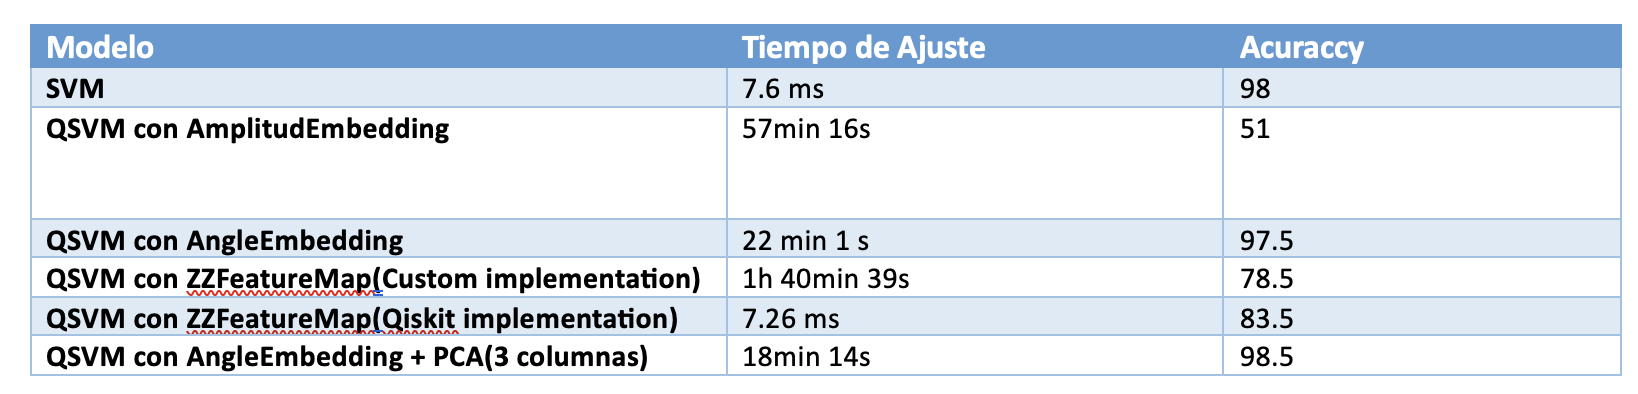



# Pendientes a fecha de 12 de noviembre de 2023

Destacar que solo hemos probado modelos QSVM y su equivalente clásico. Queda pendiente probar modelos de deeplearning. Que no se ha aplicado en este notebook por falta de tiempo.